In [1]:
! pip install sklearn

You are using pip version 8.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# DCGAN
This notebook demos a DCGAN architecture as discussed in this paper. This code is adapted from [@rajathkumarmp's]() [implementation](https://github.com/rajathkumarmp/DCGAN/blob/master/dcgan.py)

In [12]:
from __future__ import print_function
import numpy as np
from sklearn.utils import shuffle
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.layers.core import Flatten
from keras.optimizers import SGD, Adam
from keras.datasets import mnist
from keras.utils import np_utils
from keras import initializations
K.set_image_dim_ordering('th')
%matplotlib inline

/root/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def dataInit():
    print('Loading the data')
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    X_train = np.concatenate((X_train, X_test), axis=0)
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    print('Training Data: ', X_train.shape)
    npRandom = np.random.RandomState(18)
    X_noise = []
    for i in range(X_train.shape[0]):
        randomNoise = npRandom.uniform(-1,1,100)
        X_noise.append(randomNoise)
    X_noise = np.array(X_noise)
    print('Random Noise Data: ', X_noise.shape)
    return X_train, X_noise


def initNormal(shape, name=None):
    return initializations.normal(shape, scale=0.02, name=name)

In [5]:
def saveImage(imageData, imageName, epoch, display=True, save=True):
    f, ax = plt.subplots(16, 8)
    k = 0
    for i in range(16):
        for j in range(8):
            pltImage = imageData[k][0]
            ax[i,j].imshow(pltImage, interpolation='nearest',cmap='gray_r')
            ax[i,j].axis('off')
            k = k+1
    f.set_size_inches(18.5, 10.5)
    
    f.savefig('images/'+imageName+'_after_'+str(epoch)+'_epoch.png', dpi = 100, bbox_inches='tight', pad_inches = 0)
    if display:
        plt.show()
    plt.close(f)

## Model parameters

In [6]:
batchSize = 128
nbEpoch = 200
decayIter = 100
lr = 0.0002

Loading the data
('Training Data: ', (70000, 28, 28))
('Random Noise Data: ', (70000, 100))
('Number of examples: ', 70000)
('Number of Batches: ', 546)
('Number of epochs: ', 200)


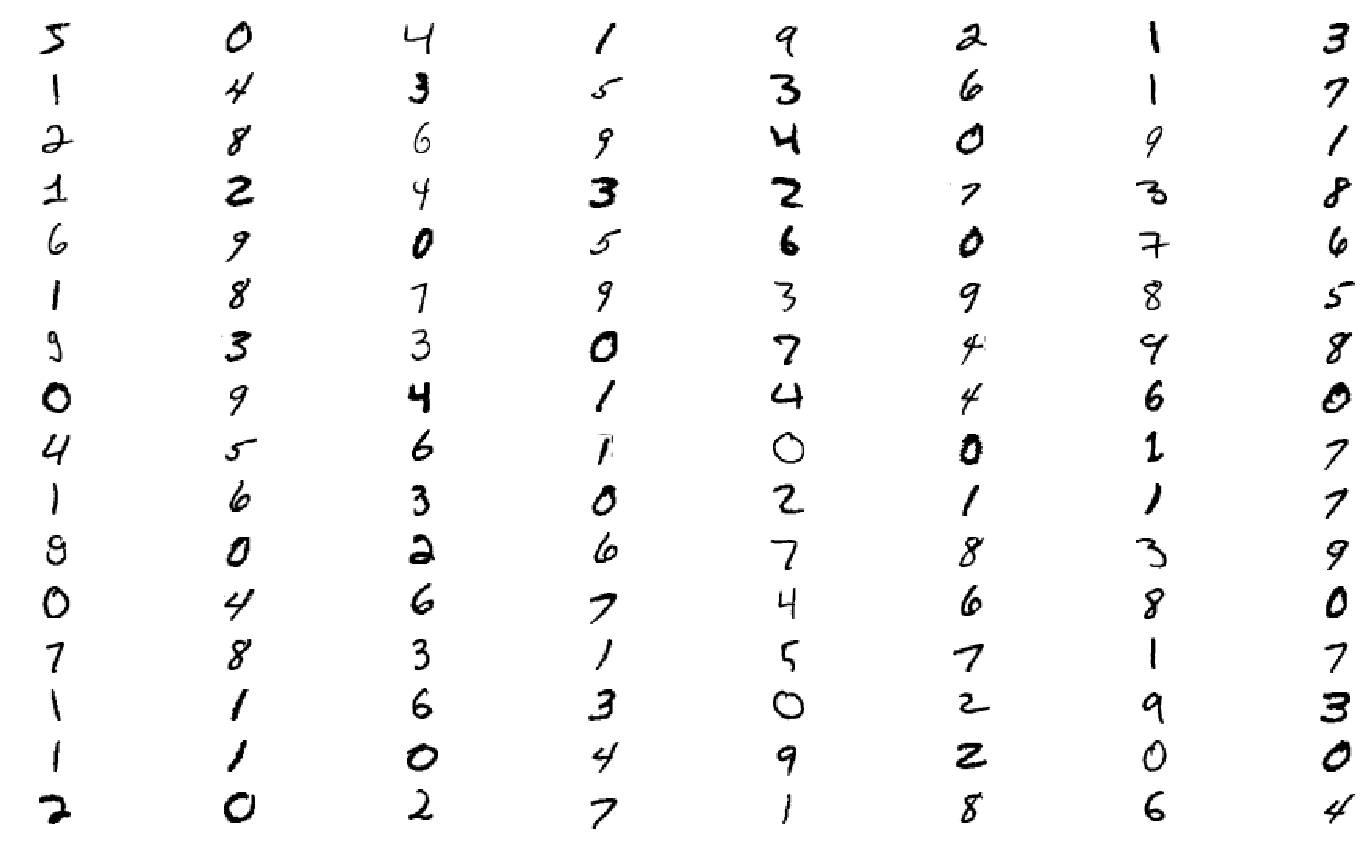

In [7]:
X_train, X_noise = dataInit()
X_train = X_train[:, np.newaxis, :, :]
numExamples = (X_train.shape)[0]
numBatches = int(numExamples/float(batchSize))
print('Number of examples: ', numExamples)
print('Number of Batches: ', numBatches)
print('Number of epochs: ', nbEpoch)
print('Sample data')
saveImage(X_train[:128], 'sample', 1, save=False)

### Generator Model setup

In [8]:
adam=Adam(lr=lr, beta_1=0.5 )

generator = Sequential()
generator.add(Dense( input_dim=100, output_dim=(128*7*7), init=initNormal))
generator.add(Activation('relu'))
generator.add(Reshape((128, 7, 7)))    
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Convolution2D(64, 5, 5, border_mode='same'))
generator.add(Activation('relu'))        
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Convolution2D(1, 5, 5, border_mode='same'))
generator.add(Activation('tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

### Discriminator Model Init 

In [9]:
discriminator = Sequential()
discriminator.add(Convolution2D(64, 5, 5, border_mode='same', subsample=(2,2), input_shape=(1,28,28), init=initNormal))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Convolution2D(128, 5, 5, border_mode='same', subsample=(2,2)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dense(1))
discriminator.add(Activation('sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

### DCGAN model
Bringing it all together

In [10]:
discriminator.trainable = False
dcganInput = Input(shape=(100,))
x = generator(dcganInput)
dcganOutput = discriminator(x)
dcgan = Model(input=dcganInput, output=dcganOutput)
dcgan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

discriminator.trainable = True

# Training 

In [11]:
if not os.path.exists('images'):
    os.makedirs('images')
if not os.path.exists('models'):
    os.makedirs('models')
if not os.path.exists('metrics'):
    os.makedirs('metrics')

dLoss = []
gLoss = []

for epoch in range(1, nbEpoch + 1):
    print('Epoch: ', epoch)

    for i in range(numBatches):
        noisePredictBatch = X_noise[np.random.randint(numExamples, size = batchSize)]
        noiseDataBatch = generator.predict(noisePredictBatch)
        origDataBatch = X_train[np.random.randint(numExamples, size = batchSize)]
        noiseLabelsBatch, origLabelsBatch = np.zeros(batchSize).astype(int), np.ones(batchSize).astype(int)
        trainBatch = np.concatenate((noiseDataBatch, origDataBatch), axis = 0)
        trainLabels = np.concatenate((noiseLabelsBatch, origLabelsBatch))
        trainBatch, trainLabels = shuffle(trainBatch, trainLabels)
        discriminatorLoss = discriminator.train_on_batch(trainBatch, trainLabels)
        dcganLabels = np.ones(batchSize).astype(int)            
        discriminator.trainable = False
        dcganLoss = dcgan.train_on_batch(noisePredictBatch, dcganLabels)
        discriminator.trainable = True

    dLoss.append(discriminatorLoss)
    gLoss.append(dcganLoss)

    if (epoch % 5 == 0) or (epoch == 1):
        saveImage(noiseDataBatch, 'generated', epoch)
        print('after epoch: ', epoch)
        print ('dcgan Loss: ', dcganLoss, '\t discriminator loss', discriminatorLoss)
        generator.save('models/generator_'+str(epoch)+'.h5')

    if epoch > decayIter :
        lrD = discriminator.optimizer.lr.get_value()
        lrG = generator.optimizer.lr.get_value()
        discriminator.optimizer.lr.set_value((lrD - lr/decayIter).astype(np.float32))
        generator.optimizer.lr.set_value((lrG - lr/decayIter).astype(np.float32))
        print('learning rate linearly decayed')

np.save('metrics/dLoss.npy', np.array(dLoss))
np.save('metrics/gLoss.npy', np.array(gLoss))

('Epoch: ', 1)


KeyboardInterrupt: 